In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D
from keras import optimizers
import matplotlib.pyplot as plt
import math 

Using TensorFlow backend.


In [2]:
#Variable Definition
img_width, img_height = 256, 256
top_model_weights_path = 'temporal/bottleneck_fc_model.h5'
epochs = 30 
batch_size = 30

In [3]:
#VGG16 Model
from keras.applications import vgg16

vgg16 = vgg16.VGG16(include_top=False, weights='imagenet')

In [4]:
#Data Augmentation and Bottleneck features generation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1. / 255
)

In [5]:
# Training Bottleneck
generator  = datagen.flow_from_directory('Data/BusinessCardClassifier/shape/train/',
                                         shuffle=False,
                                         class_mode=None,
                                         batch_size=batch_size,
                                         target_size=(img_width, img_height))

nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 

np.save('temporal/bottleneck_features_train.npy', bottleneck_features_train)

Found 335 images belonging to 2 classes.


C:\Users\Xavi\Anaconda3\envs\TFM\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [6]:
# Validation Bottleneck
generator  = datagen.flow_from_directory('Data/BusinessCardClassifier/shape/test/',
                                         shuffle=False,
                                         class_mode=None,
                                         batch_size=batch_size,
                                         target_size=(img_width, img_height))

nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices)

predict_size_validation = int(math.ceil(nb_train_samples / batch_size)) 

bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 

np.save('temporal/bottleneck_features_validation.npy', bottleneck_features_validation)

Found 103 images belonging to 2 classes.


In [7]:
# Training Data set
generator_top = datagen.flow_from_directory( 
   'Data/BusinessCardClassifier/shape/train/', 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
train_data = np.load('temporal/bottleneck_features_train.npy') 
train_labels = generator_top.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 335 images belonging to 2 classes.


In [8]:
# Validation Data Set
generator_top = datagen.flow_from_directory( 
   'Data/BusinessCardClassifier/shape/test/', 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
validation_data = np.load('temporal/bottleneck_features_validation.npy') 
validation_labels = generator_top.classes 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 103 images belonging to 2 classes.


In [9]:
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100)) 
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.5)) 
model.add(Dense(50))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels, 
   epochs=epochs,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,     verbose=1)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 335 samples, validate on 103 samples
Epoch 1/30
335/335 [==============================] - 1s 3ms/step - loss: 0.5211 - acc: 0.8149 - val_loss: 0.3579 - val_acc: 0.9029
Epoch 2/30
335/335 [==============================] - 0s 1ms/step - loss: 0.3709 - acc: 0.8836 - val_loss: 0.3601 - val_acc: 0.9029
Epoch 3/30
335/335 [==============================] - 0s 1ms/step - loss: 0.3244 - acc: 0.8985 - val_loss: 0.3072 - val_acc: 0.9029
Epoch 4/30
335/335 [==============================] - 0s 1ms/step - loss: 0.2670 - acc: 0.9015 - val_loss: 0.3850 - val_acc: 0.9029
Epoch 5/30
335/335 [==============================] - 0s 1ms/step - loss: 0.2369 - acc: 0.9164 - val_loss: 0.3013 - val_acc: 0.8932
Epoch 6/30
335/335 [==============================] - 0s 1ms/step - loss: 0.2011

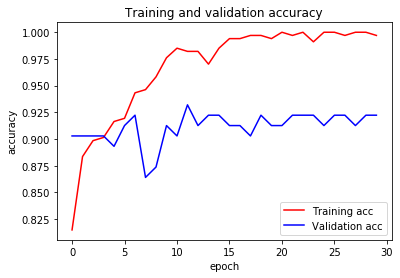

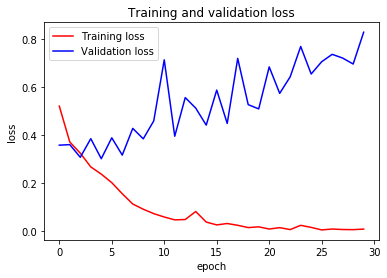

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [11]:
from sklearn import metrics
preds = np.round(model.predict(validation_data), 0)
predicted_classes = np.argmax(preds, axis=1)
true_classes = generator_top.classes
class_labels = list(generator_top.class_indices.keys())


In [12]:
report = metrics.classification_report(validation_labels, preds, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

     rounded       1.00      0.20      0.33        10
      square       0.92      1.00      0.96        93

   micro avg       0.92      0.92      0.92       103
   macro avg       0.96      0.60      0.65       103
weighted avg       0.93      0.92      0.90       103
 samples avg       0.92      0.92      0.92       103



In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

categorical_test_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

cm = confusion_matrix(categorical_test_labels, categorical_preds)

def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="black" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

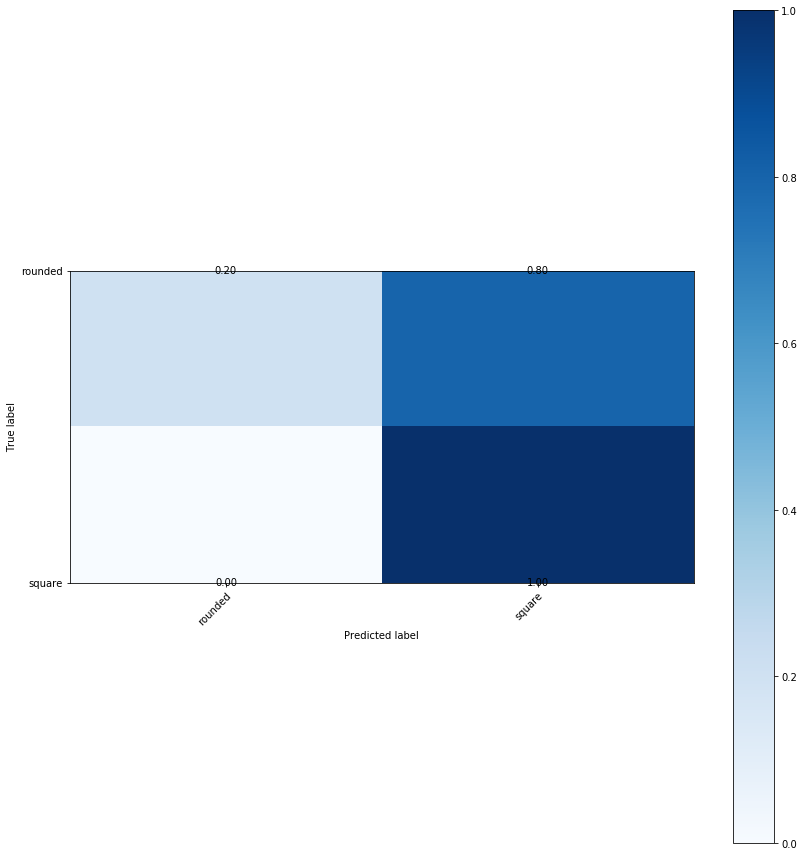

In [14]:
plot_confusion_matrix(cm, class_labels, normalize=True)

In [15]:
#Save the model

vgg16_yaml = vgg16.to_yaml()
with open("Model/bc_shape_classification_vgg16_model.yaml", "w") as yaml_file:
    yaml_file.write(vgg16_yaml)
vgg16.save_weights("Model/bc_shape_classification_vgg16.h5")

model_yaml = model.to_yaml()
with open("Model/bc_shape_classification_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights("Model/bc_shape_classification_model.h5")